#### Theoretical Delivered Bias Statistics in a Fundamental Factor Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import linregress
import statsmodels.api as sm

In order to test out the bias statistics for a theoretical fundamental factor model, we need to generate a theoretical market with a structure perfectly matching that of the axioms of a fundamental factor model. We can then run tests for the true and empirical risks of the portfolio as captured by the fundamental factor model we generate for that portfolio. 

In [2]:
# Underlying Factor Structure Characteristics
ex_ante_factor_structure = {
    'volatility': (0,6,'z-score'),
    'quality': (2,6,'z-score'),
    'size': (-2,6,'z-score'),
    'tech': (2,10, 'dummy',0.1),
    'missing_factor': (0.5, 3, 'z-score'),
    'overfit_factor': (0, 0, 'z-score')
}
stock_specific_vol = 20

# Market Structure Characteristics
market_size = 1000
estimation_window = 1260

# Portfolio Structure Characteristics
port_size = 60
port_number = 200

##### Create a universe of securities with the given factor structure

First we will generate a market of the given size, and randomly create a set of orthogonal factor exposures with the desired properties. 

In [3]:
# Generate exposures for a market of the given size
market_exposures = pd.DataFrame(index=range(market_size), columns=ex_ante_factor_structure.keys())
for factor in ex_ante_factor_structure.keys():
    if ex_ante_factor_structure[factor][2] == 'z-score':
        # For z-scored factors we draw exposures from a normal distribution
        market_exposures[factor] = np.random.normal(0, 1, market_size)
    elif ex_ante_factor_structure[factor][2] == 'dummy':
        market_exposures[factor] = np.where(np.random.uniform(0, 1, market_size)<=ex_ante_factor_structure[factor][3],1,0)
    else:
        raise ValueError

##### Generate factor and idiosyncratic returns

Next we will generate factor returns for the given time period, and idiosyncratic returns for each security in the market based on the given structure. 

In [4]:
# Generate factor returns for the given time period 
true_factor_returns = pd.DataFrame(index=ex_ante_factor_structure.keys(), columns=range(estimation_window))
for factor in ex_ante_factor_structure.keys():
    mean = ex_ante_factor_structure[factor][0] / 252
    vol = ex_ante_factor_structure[factor][1] / (252 ** 0.5)
    if vol > 0:
        # If the factor has volatility, draw from an appropriate normal distribution 
        true_factor_returns.loc[factor] = np.random.normal(mean, vol, estimation_window)
    else:
        true_factor_returns.loc[factor] = pd.Series(mean, index=true_factor_returns.columns)
        
# Generate idiosyncratic returns across stocks for the given time period 
true_idio_returns = pd.DataFrame(np.random.normal(0, stock_specific_vol / (252 ** 0.5), (estimation_window, market_size)))

These factor returns and idiosyncratic returns will be used to generate the security returns for the market:

In [5]:
# Calculate security returns
ex_post_returns = pd.DataFrame(0, index=range(market_size), columns=range(estimation_window))

for date in tqdm(ex_post_returns.columns):
    ex_post_returns[date] = market_exposures.dot(true_factor_returns[date]) + true_idio_returns.loc[date]

ex_post_returns = ex_post_returns.astype(float)

100%|██████████| 1260/1260 [00:01<00:00, 1101.31it/s]


##### Estimate Factor Models

Estimate the empirical factor and idiosyncratic returns under the factor model and generate a covariance matrix from the factor returns. We do this for a small model as well as an overfit model to see what the effect on risk is.

In [6]:
# Estimate empirical factor returns from the security returns

# Generate empty dataframes
excluded_factors = [x for x in ex_ante_factor_structure.keys() if 'missing' in x or 'overfit' in x]
small_model_factor_returns = pd.DataFrame(index=[x for x in true_factor_returns.index if x not in excluded_factors],
                                          columns=range(estimation_window))
small_model_idio_returns = pd.DataFrame(index=range(market_size), columns=range(estimation_window))
small_model_rsq = {}

full_model_factor_returns = pd.DataFrame(index=true_factor_returns.index,
                                         columns=range(estimation_window))
full_model_idio_returns = pd.DataFrame(index=range(market_size), columns=range(estimation_window))
full_model_rsq = {}

# Get market exposures coefficients for included factors only
small_model_exposures = market_exposures.drop(excluded_factors, axis=1).copy()

# Period by period, estimate within-period factor returns and idiosyncratic returns to go with it
for date in tqdm(ex_post_returns.columns):
    # Generate small model factor and idiosyncratic returns
    mod = sm.OLS(ex_post_returns[date].to_numpy(), small_model_exposures.to_numpy())
    res = mod.fit()
    small_model_factor_returns[date] = res.params.transpose()
    small_model_idio_returns[date] = res.resid
    small_model_rsq[date] = res.rsquared
    
    # Generate full model factor returns and idiosyncratic returns
    mod = sm.OLS(ex_post_returns[date].to_numpy(), market_exposures.to_numpy())
    res = mod.fit()
    full_model_factor_returns[date] = res.params.transpose()
    full_model_idio_returns[date] = res.resid
    full_model_rsq[date] = res.rsquared

100%|██████████| 1260/1260 [00:02<00:00, 592.43it/s]


In [7]:
# Generate theoretical covariance matrix and idiosyncratic vols
true_model_cov_matrix = pd.DataFrame(0., index=ex_ante_factor_structure.keys(), columns=ex_ante_factor_structure.keys())
for factor in ex_ante_factor_structure.keys():
    true_model_cov_matrix.loc[factor, factor] = ex_ante_factor_structure[factor][1] ** 2
true_model_idio_vols = pd.Series(stock_specific_vol, index=range(market_size))

In [8]:
##### Create Small Model

# Generate empirical covariance matrix
small_model_cov_matrix = small_model_factor_returns.transpose().cov() * 252
for factor in excluded_factors:
    small_model_cov_matrix[factor] = 0.
    small_model_cov_matrix.loc[factor] = 0.
small_model_cov_matrix = small_model_cov_matrix.loc[true_model_cov_matrix.index, true_model_cov_matrix.columns].copy()

# Generate idiosyncratic vols
small_model_idio_vols = small_model_idio_returns.std(axis=1) * (252 ** 0.5)

In [9]:
##### Estimate Full Model

# Generate empirical covariance matrix
full_model_cov_matrix = full_model_factor_returns.transpose().cov() * 252

# Generate idiosyncratic vols
full_model_idio_vols = full_model_idio_returns.std(axis=1) * (252 ** 0.5)

Text(0.5, 0.4, 'Average Daily R-squared:\nUnderfit model: 0.202\nOverfit model: 0.220\n')

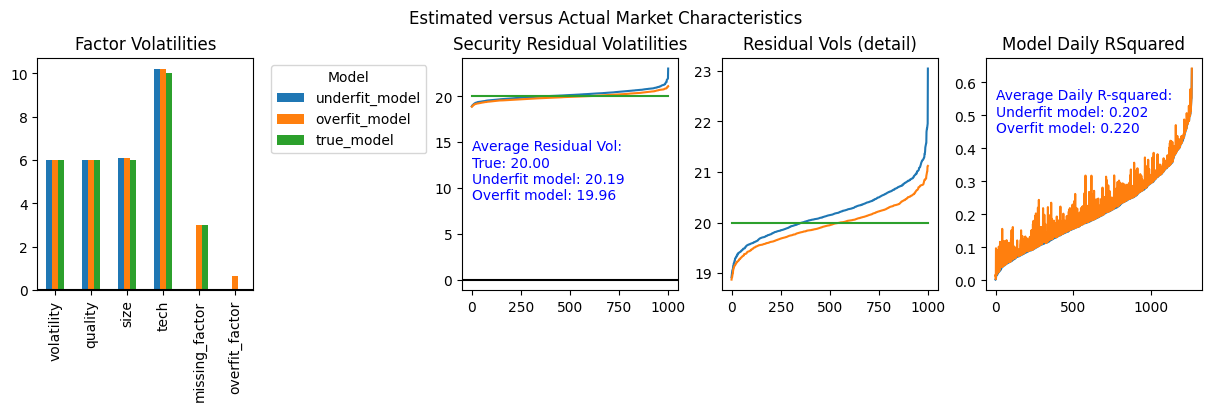

In [10]:
# Generate a vector of theoretical vs true factor vols
factor_vols = pd.DataFrame(index=ex_ante_factor_structure.keys())
factor_vols['underfit_model'] = np.diag(small_model_cov_matrix) ** 0.5
factor_vols['overfit_model'] = np.diag(full_model_cov_matrix) ** 0.5
factor_vols['true_model'] = np.diag(true_model_cov_matrix) ** 0.5

# Compare the distribution of idiosyncratic vols
idio_vols = pd.DataFrame(index=range(market_size))
idio_vols['underfit_model'] = small_model_idio_vols.sort_values().reset_index(drop=True)
idio_vols['overfit_model'] = full_model_idio_vols.sort_values().reset_index(drop=True)
idio_vols['true_volatilities'] = true_model_idio_vols.sort_values().reset_index(drop=True)

# Generate series of RSquared values
rsq = pd.DataFrame({'underfit_model': small_model_rsq, 'overfit_model': full_model_rsq})

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,4), constrained_layout=True)
fig.suptitle('Estimated versus Actual Market Characteristics')
factor_vols.plot.bar(ax=ax1, title='Factor Volatilities')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
ax1.axhline(0, color='k')
idio_vols.plot.line(ax=ax2, title='Security Residual Volatilities', legend=False)
ax2.axhline(0, color='k')
idio_vols.plot.line(ax=ax3, title='Residual Vols (detail)', legend=False)
ax2.text(x=0.5, y=7, 
         s=f'Average Residual Vol:\nTrue: {true_model_idio_vols.mean():.2f}\nUnderfit model: {small_model_idio_vols.mean():.2f}\nOverfit model: {full_model_idio_vols.mean():.2f}\n', 
         color='b')
rsq.sort_values('underfit_model').reset_index(drop=True).plot(ax=ax4, title='Model Daily RSquared', legend=False)
ax4.text(x=0.5, y=0.4, 
         s=f'Average Daily R-squared:\nUnderfit model: {rsq.underfit_model.mean():.3f}\nOverfit model: {rsq.overfit_model.mean():.3f}\n', 
         color='b')

#### Create Portfolios for Risk Estimate Testing 
 
Generate a set of random equal-weight portfolios which we can then estimate theoretical and empirical risk statistics for

In [11]:
# Generate a set of random equal-weight portfolios
portfolios = pd.DataFrame(0., index=range(market_size), columns=range(port_number))
for port in tqdm(portfolios.columns):
    portfolios.loc[np.random.choice(range(market_size), port_size, replace=False).tolist(), port] = 1 / port_size

100%|██████████| 200/200 [00:00<00:00, 2764.82it/s]


In [12]:
# Calculate the factor exposure vector for each portfolio
port_exposures = portfolios.transpose().dot(market_exposures)

# Calculate ex-post returns and delivered for each portfolio
port_ex_post_returns = portfolios.transpose().dot(ex_post_returns)
port_ex_post_vol = pd.Series(port_ex_post_returns.std(axis=1) * (252 ** 0.5), name='ex_post_vol')

#### Generate Risk Estimates

In [13]:
# Generate CAR breakdown for the true model
port_car = {}
for port_id, port_pos in tqdm(portfolios.transpose().iterrows()):
    port_exposures = port_pos.dot(market_exposures)
    port_var_contribs_temp = port_exposures.dot(true_model_cov_matrix) * port_exposures
    port_var_contribs_temp.loc['idio'] = np.sum((port_pos * true_model_idio_vols) ** 2)
    port_car[port_id] = port_var_contribs_temp / (np.sum(port_var_contribs_temp) ** 0.5)
    
true_model_port_car = pd.DataFrame(port_car)

200it [00:00, 923.96it/s]


In [14]:
# Generate CAR breakdown for the small model
port_car = {}
for port_id, port_pos in tqdm(portfolios.transpose().iterrows()):
    port_exposures = port_pos.dot(market_exposures)
    port_var_contribs_temp = port_exposures.dot(small_model_cov_matrix) * port_exposures
    port_var_contribs_temp.loc['idio'] = np.sum((port_pos * small_model_idio_vols) ** 2)
    port_car[port_id] = port_var_contribs_temp / (np.sum(port_var_contribs_temp) ** 0.5)
    
small_model_port_car = pd.DataFrame(port_car)

200it [00:00, 974.03it/s]


In [15]:
# Generate CAR breakdown for the full model
port_car = {}
for port_id, port_pos in tqdm(portfolios.transpose().iterrows()):
    port_exposures = port_pos.dot(market_exposures)
    port_var_contribs_temp = port_exposures.dot(full_model_cov_matrix) * port_exposures
    port_var_contribs_temp.loc['idio'] = np.sum((port_pos * full_model_idio_vols) ** 2)
    port_car[port_id] = port_var_contribs_temp / (np.sum(port_var_contribs_temp) ** 0.5)
    
full_model_port_car = pd.DataFrame(port_car)

200it [00:00, 919.70it/s]


#### Compare Risk Estimates

<Axes: >

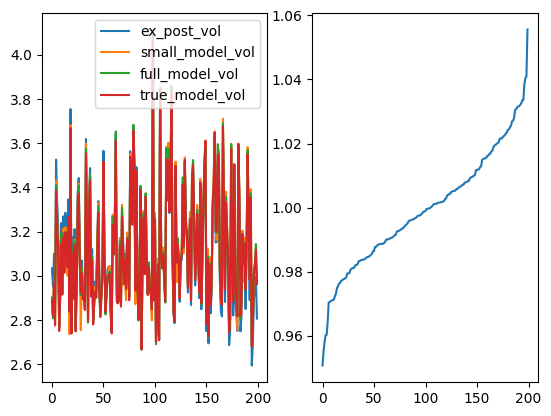

In [16]:
# Generate model car comparison
port_car_comparison = pd.DataFrame(port_ex_post_vol)
port_car_comparison['small_model_vol'] = np.sum(small_model_port_car, axis=0)
port_car_comparison['full_model_vol'] = np.sum(full_model_port_car, axis=0)
port_car_comparison['true_model_vol'] = np.sum(true_model_port_car, axis=0)
port_car_comparison['model_bias'] = port_car_comparison['true_model_vol'] / port_car_comparison['ex_post_vol']

fig, (ax1, ax2) = plt.subplots(1,2)
port_car_comparison.sort_values('model_bias').reset_index(drop=True)[[x for x in port_car_comparison.columns if 'vol' in x]].plot.line(ax=ax1)
port_car_comparison.sort_values('model_bias').reset_index(drop=True)['model_bias'].plot.line(ax=ax2)

#### Ex-Post and Ex-Ante Risk versus Risk MOdel Estimates

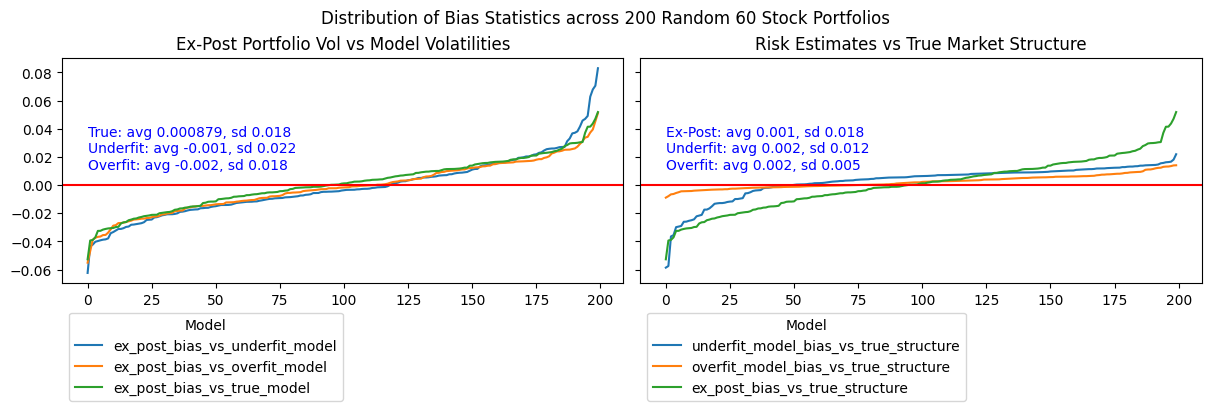

In [17]:
# Generate summary bias statistics
ex_post_bias_distribution = pd.DataFrame((port_car_comparison.ex_post_vol / port_car_comparison.small_model_vol - 1).sort_values().reset_index(drop=True).rename('ex_post_bias_vs_underfit_model'))
ex_post_bias_distribution['ex_post_bias_vs_overfit_model'] = (port_car_comparison.ex_post_vol / port_car_comparison.full_model_vol - 1).sort_values().reset_index(drop=True)
ex_post_bias_distribution['ex_post_bias_vs_true_model'] = (port_car_comparison.ex_post_vol / port_car_comparison.true_model_vol - 1).sort_values().reset_index(drop=True)

# Get contributions to bias for full model
true_bias_distribution = pd.DataFrame((port_car_comparison.small_model_vol / port_car_comparison.true_model_vol - 1).sort_values().reset_index(drop=True).rename('underfit_model_bias_vs_true_structure'))
true_bias_distribution['overfit_model_bias_vs_true_structure'] = (port_car_comparison.full_model_vol / port_car_comparison.true_model_vol - 1).sort_values().reset_index(drop=True)
true_bias_distribution['ex_post_bias_vs_true_structure'] = (port_car_comparison.ex_post_vol / port_car_comparison.true_model_vol - 1).sort_values().reset_index(drop=True)

# Generate comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle(f'Distribution of Bias Statistics across {port_number} Random {port_size} Stock Portfolios')
ex_post_bias_distribution.plot(ax=ax1, title='Ex-Post Portfolio Vol vs Model Volatilities')
true_bias_distribution.plot(ax=ax2, title='Risk Estimates vs True Market Structure')
# Plot data for tests of the model against the real world
ax1.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', title='Model')
ax1.text(x=0, y=0, s=f'True: avg {ex_post_bias_distribution.ex_post_bias_vs_true_model.mean():.3}, sd {ex_post_bias_distribution.ex_post_bias_vs_true_model.std():.3f}\nUnderfit: avg {ex_post_bias_distribution.ex_post_bias_vs_underfit_model.mean():.3f}, sd {ex_post_bias_distribution.ex_post_bias_vs_underfit_model.std():.3f}\nOverfit: avg {ex_post_bias_distribution.ex_post_bias_vs_overfit_model.mean():.3f}, sd {ex_post_bias_distribution.ex_post_bias_vs_overfit_model.std():.3f}\n', color='b')
ax1.axhline(0, color='r')
# Plot data for tests of the models and delivered outcomes against the true model structure
ax2.legend(bbox_to_anchor=(0.0, -0.1), loc='upper left', title='Model')
ax2.text(x=0, y=0, s=f'Ex-Post: avg {true_bias_distribution.ex_post_bias_vs_true_structure.mean():.3f}, sd {true_bias_distribution.ex_post_bias_vs_true_structure.std():.3f}\nUnderfit: avg {true_bias_distribution.underfit_model_bias_vs_true_structure.mean():.3f}, sd {true_bias_distribution.underfit_model_bias_vs_true_structure.std():.3f}\nOverfit: avg {true_bias_distribution.overfit_model_bias_vs_true_structure.mean():.3f}, sd {true_bias_distribution.overfit_model_bias_vs_true_structure.std():.3f}\n', color='b')
ax2.axhline(0, color='r')

#### Single Model Risk Bias Comparisons

<Axes: title={'center': 'Contributions(Smoothed)'}>

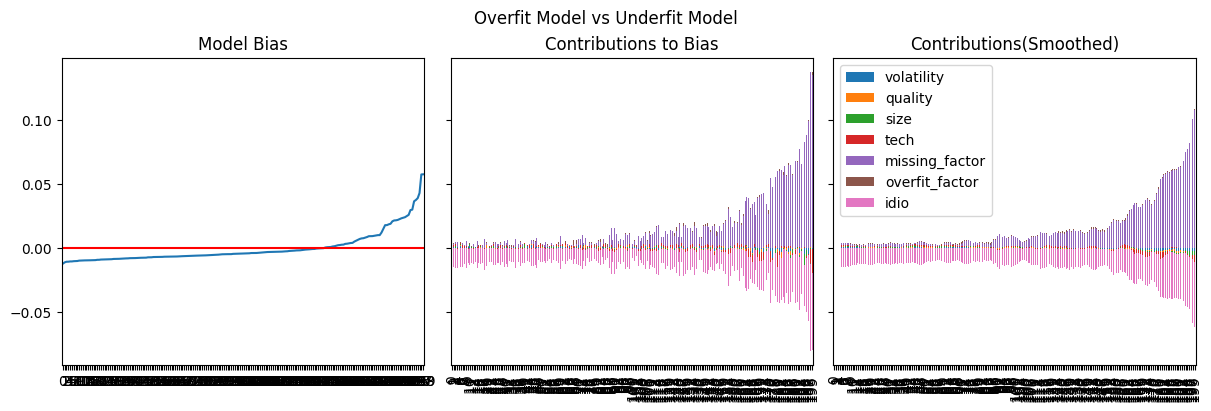

In [18]:
# Compare the distribution of risk contributions for the small and full models
bias_contribs = full_model_port_car - small_model_port_car
bias_contribs  = (bias_contribs / np.sum(small_model_port_car, axis=0)).copy()
bias = (np.sum(full_model_port_car, axis=0) / np.sum(small_model_port_car, axis=0)) - 1

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('Overfit Model vs Underfit Model')
bias.sort_values().reset_index(drop=True).plot.line(title='Model Bias', ax=ax1)
ax1.axhline(0, color='r')
bias_contribs.transpose().loc[bias.sort_values().index.to_list()].reset_index(drop=True).plot.bar(stacked=True, title='Contributions to Bias', ax=ax2, legend=False)
bias_contribs.transpose().loc[bias.sort_values().index.to_list()].reset_index(drop=True).rolling(5).mean().plot.bar(stacked=True, title='Contributions(Smoothed)', ax=ax3)

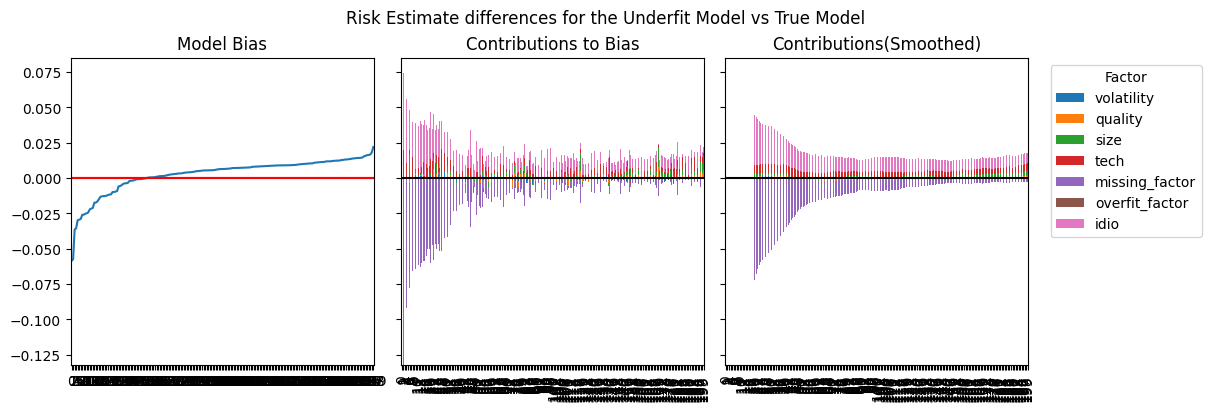

In [19]:
# Calculate bias statistics for the small model versus the true underlying model
small_vs_true_bias_contribs = small_model_port_car - true_model_port_car
small_vs_true_bias_contribs  = (small_vs_true_bias_contribs / np.sum(true_model_port_car, axis=0)).copy()
bias = (np.sum(small_model_port_car, axis=0) / np.sum(true_model_port_car, axis=0)) - 1
small_vs_true_bias_contribs = small_vs_true_bias_contribs[bias.sort_values().index.to_list()].copy()
small_vs_true_bias_contribs.columns = range(small_vs_true_bias_contribs.shape[1])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('Risk Estimate differences for the Underfit Model vs True Model')
bias.sort_values().reset_index(drop=True).plot.line(title='Model Bias', ax=ax1)
ax1.axhline(0, color='r')
small_vs_true_bias_contribs.transpose().plot.bar(stacked=True, title='Contributions to Bias', ax=ax2, legend=False)
small_vs_true_bias_contribs.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Contributions(Smoothed)', ax=ax3)
ax1.axhline(0, color='r')
ax2.axhline(0, color='k')
ax3.axhline(0, color='k')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Factor')

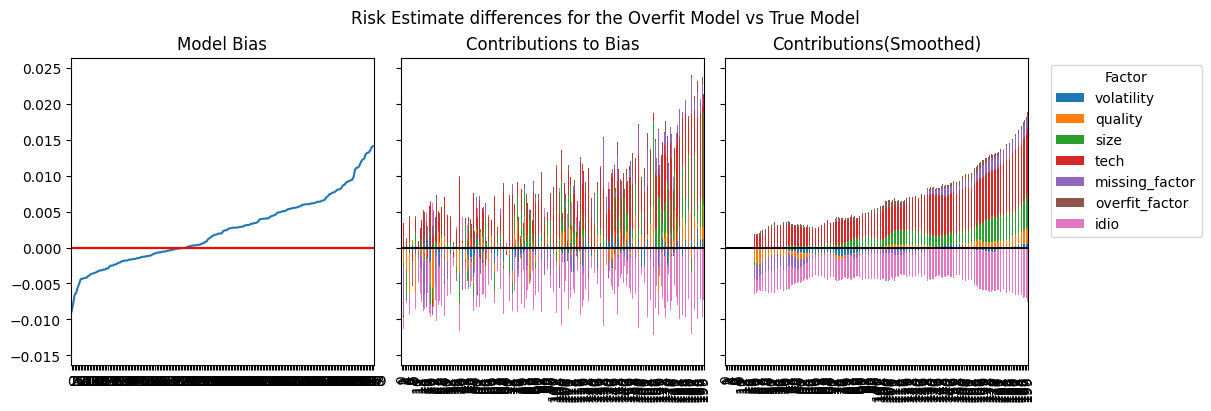

In [20]:
full_vs_true_bias_contribs = full_model_port_car - true_model_port_car
full_vs_true_bias_contribs  = (full_vs_true_bias_contribs / np.sum(true_model_port_car, axis=0)).copy()
bias = (np.sum(full_model_port_car, axis=0) / np.sum(true_model_port_car, axis=0)) - 1
full_vs_true_bias_contribs = full_vs_true_bias_contribs[bias.sort_values().index.to_list()].copy()
full_vs_true_bias_contribs.columns = range(full_vs_true_bias_contribs.shape[1])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('Risk Estimate differences for the Overfit Model vs True Model')
bias.sort_values().reset_index(drop=True).plot.line(title='Model Bias', ax=ax1)
ax1.axhline(0, color='r')
full_vs_true_bias_contribs.transpose().plot.bar(stacked=True, title='Contributions to Bias', ax=ax2, legend=False)
full_vs_true_bias_contribs.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Contributions(Smoothed)', ax=ax3)
ax1.axhline(0, color='r')
ax2.axhline(0, color='k')
ax3.axhline(0, color='k')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Factor')

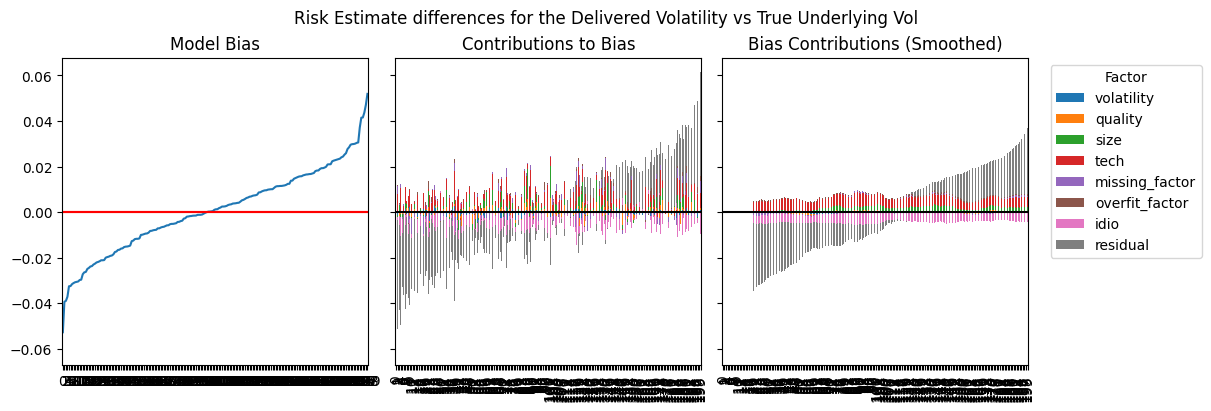

In [21]:
# Ex Post vs True Model (with Full Model Decomposition)
ex_post_vs_ex_ante_bias = full_model_port_car - true_model_port_car
ex_post_vs_ex_ante_bias.loc['residual'] = port_car_comparison.ex_post_vol - port_car_comparison.full_model_vol
ex_post_vs_ex_ante_bias  = (ex_post_vs_ex_ante_bias / port_car_comparison.true_model_vol).copy()
bias = (port_car_comparison.ex_post_vol / port_car_comparison.true_model_vol) - 1
ex_post_vs_ex_ante_bias = ex_post_vs_ex_ante_bias[bias.sort_values().index.to_list()].copy()
ex_post_vs_ex_ante_bias.columns = range(ex_post_vs_ex_ante_bias.shape[1])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('Risk Estimate differences for the Delivered Volatility vs True Underlying Vol')
bias.sort_values().reset_index(drop=True).plot.line(title='Model Bias', ax=ax1)
ax1.axhline(0, color='r')
ex_post_vs_ex_ante_bias.transpose().plot.bar(stacked=True, title='Contributions to Bias', ax=ax2, legend=False)
ex_post_vs_ex_ante_bias.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Bias Contributions (Smoothed)', ax=ax3)
ax1.axhline(0, color='r')
ax2.axhline(0, color='k')
ax3.axhline(0, color='k')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Factor')

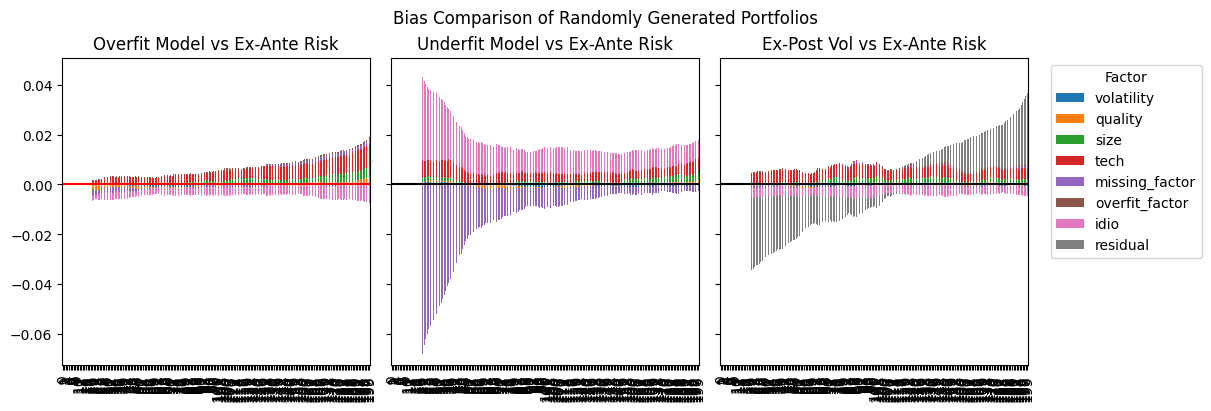

In [22]:
# Get bias comparison for the small and overfit models versus the true underlying model
bias_comparison = pd.DataFrame(pd.Series((np.sum(small_model_port_car, axis=0) / np.sum(true_model_port_car, axis=0)) - 1).sort_values().reset_index(drop=True).rename('small_model_bias'))
bias_comparison['full_model_bias'] = ((np.sum(full_model_port_car, axis=0) / np.sum(true_model_port_car, axis=0)) - 1).sort_values().reset_index(drop=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharey=True, sharex=True, constrained_layout=True)
fig.suptitle('Bias Comparison of Randomly Generated Portfolios')
full_vs_true_bias_contribs.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Overfit Model vs Ex-Ante Risk', ax=ax1, legend=False)
small_vs_true_bias_contribs.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Underfit Model vs Ex-Ante Risk', ax=ax2, legend=False)
ex_post_vs_ex_ante_bias.transpose().rolling(int(port_number/10)).mean().plot.bar(stacked=True, title='Ex-Post Vol vs Ex-Ante Risk', ax=ax3)
ax1.axhline(0, color='r')
ax2.axhline(0, color='k')
ax3.axhline(0, color='k')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Factor')